In [1]:
from fastai.text.all import *
from fastai.callback.progress import CSVLogger

In [2]:
path = Path('data/dewiki_lstm_15k')
model_path = path/'model'
data_path = Path('data/dewiki_160k/docs_160k')
lang = 'de'

In [3]:
bs=128

In [4]:
tok = SentencePieceTokenizer(lang=lang, max_vocab_sz=15000)

In [5]:
dblock = DataBlock(blocks=TextBlock.from_folder(data_path, is_lm=True, tok=tok),
                   get_items=get_files,
                   splitter=RandomSplitter(valid_pct=0.1, seed=42),
                  )

dls = dblock.dataloaders(data_path, path=data_path, bs=bs, num_workers=18)

In [6]:
dls.show_batch()

,text,text_
0,▁xxbos ▁xxmaj ▁gerd ▁xxmaj ▁schön felder ▁( intendant ) ▁xxmaj ▁max ▁xxmaj ▁gerd ▁xxmaj ▁schön felder ▁(* ▁27. ▁xxmaj ▁april ▁1936 ▁in ▁xxmaj ▁kö t te witz ; ▁† ▁12. ▁xxmaj ▁oktober ▁2 ▁xxrep ▁3 ▁0 ▁in ▁xxmaj ▁dresden ) ▁war ▁ein ▁deutscher ▁xxmaj ▁musik wissenschaftler ▁und ▁xxmaj ▁ intendant . ▁xxmaj ▁schön felder ▁stammte ▁aus ▁dem ▁xxmaj ▁oster z gebirge ▁und ▁besuchte ▁xxmaj ▁schulen ▁in ▁xxmaj ▁do h na ▁und ▁xxmaj,▁xxmaj ▁gerd ▁xxmaj ▁schön felder ▁( intendant ) ▁xxmaj ▁max ▁xxmaj ▁gerd ▁xxmaj ▁schön felder ▁(* ▁27. ▁xxmaj ▁april ▁1936 ▁in ▁xxmaj ▁kö t te witz ; ▁† ▁12. ▁xxmaj ▁oktober ▁2 ▁xxrep ▁3 ▁0 ▁in ▁xxmaj ▁dresden ) ▁war ▁ein ▁deutscher ▁xxmaj ▁musik wissenschaftler ▁und ▁xxmaj ▁ intendant . ▁xxmaj ▁schön felder ▁stammte ▁aus ▁dem ▁xxmaj ▁oster z gebirge ▁und ▁besuchte ▁xxmaj ▁schulen ▁in ▁xxmaj ▁do h na ▁und ▁xxmaj ▁
1,"▁drei ▁xxmaj ▁single s , ▁unter ▁denen ▁auch ▁der ▁erste ▁von ▁xxmaj ▁ t hain ▁geschrieben e ▁und ▁veröffentlichte ▁xxmaj ▁song ▁"" i ’ d ▁xxmaj ▁ ne ver ▁xxmaj ▁be ▁xxmaj ▁ blue "" ▁enthalten ▁war . ▁xxmaj ▁als ▁sich ▁die ▁"" strang ers "" ▁auf lös ten , ▁stieg ▁er ▁bei ▁den ▁ ' secret s ' ▁ein , ▁mit ▁der ▁er ▁eine ▁xxmaj ▁single ▁veröffentlichte . ▁xxmaj ▁noch ▁im","▁xxmaj ▁single s , ▁unter ▁denen ▁auch ▁der ▁erste ▁von ▁xxmaj ▁ t hain ▁geschrieben e ▁und ▁veröffentlichte ▁xxmaj ▁song ▁"" i ’ d ▁xxmaj ▁ ne ver ▁xxmaj ▁be ▁xxmaj ▁ blue "" ▁enthalten ▁war . ▁xxmaj ▁als ▁sich ▁die ▁"" strang ers "" ▁auf lös ten , ▁stieg ▁er ▁bei ▁den ▁ ' secret s ' ▁ein , ▁mit ▁der ▁er ▁eine ▁xxmaj ▁single ▁veröffentlichte . ▁xxmaj ▁noch ▁im ▁selben"
2,"▁ ter ro r istin , ▁wurde ▁allerdings ▁von ▁westlichen ▁xxmaj ▁kommen t atoren ▁praktisch ▁allgemein ▁zurück ge wiesen . ▁xxmaj ▁die ▁im ▁xxmaj ▁ausland ▁lebende ▁xxmaj ▁u ig ur en ▁sind ▁heute ▁oft ▁stolz ▁auf ▁ihr ▁soziale s , ▁kulturelle s ▁und ▁historische s ▁xxmaj ▁erbe . ▁xxmaj ▁sie ▁sind ▁dort ▁nicht ▁nur ▁ geschäft lich ▁aktiv , ▁sondern ▁haben ▁sich ▁hohe ▁xxmaj ▁berufs qualifikation en ▁in ▁xxmaj ▁bereichen ▁wie ▁xxmaj","ter ro r istin , ▁wurde ▁allerdings ▁von ▁westlichen ▁xxmaj ▁kommen t atoren ▁praktisch ▁allgemein ▁zurück ge wiesen . ▁xxmaj ▁die ▁im ▁xxmaj ▁ausland ▁lebende ▁xxmaj ▁u ig ur en ▁sind ▁heute ▁oft ▁stolz ▁auf ▁ihr ▁soziale s , ▁kulturelle s ▁und ▁historische s ▁xxmaj ▁erbe . ▁xxmaj ▁sie ▁sind ▁dort ▁nicht ▁nur ▁ geschäft lich ▁aktiv , ▁sondern ▁haben ▁sich ▁hohe ▁xxmaj ▁berufs qualifikation en ▁in ▁xxmaj ▁bereichen ▁wie ▁xxmaj ▁"
3,"; ▁einige , ▁indem ▁sie ▁durch ▁die ▁xxmaj ▁kreis reform ▁mit ▁dem ▁xxmaj ▁haupt gebiet ▁des ▁xxmaj ▁landkreises ▁verbunden ▁wurden ▁( be uro n , ▁xxmaj ▁ thal heim ), ▁andere , ▁indem ▁sie ▁die ▁xxmaj ▁landkreis zugehörigkeit ▁wechselte n ▁( lang en en s lingen ). ▁xxmaj ▁auch ▁einige ▁weit ▁von ▁der ▁xxmaj ▁kreisstadt ▁entfernt e ▁xxmaj ▁gemeinden ▁fielen ▁zwischen ▁1969 ▁und ▁1975 ▁an ▁andere ▁xxmaj ▁landkreis e ▁( bi ber","▁einige , ▁indem ▁sie ▁durch ▁die ▁xxmaj ▁kreis reform ▁mit ▁dem ▁xxmaj ▁haupt gebiet ▁des ▁xxmaj ▁landkreises ▁verbunden ▁wurden ▁( be uro n , ▁xxmaj ▁ thal heim ), ▁andere , ▁indem ▁sie ▁die ▁xxmaj ▁landkreis zugehörigkeit ▁wechselte n ▁( lang en en s lingen ). ▁xxmaj ▁auch ▁einige ▁weit ▁von ▁der ▁xxmaj ▁kreisstadt ▁entfernt e ▁xxmaj ▁gemeinden ▁fielen ▁zwischen ▁1969 ▁und ▁1975 ▁an ▁andere ▁xxmaj ▁landkreis e ▁( bi ber ach"
4,"▁da selbst “. ▁xxmaj ▁bürgermeister ▁xxmaj ▁ s mid t ▁ weih te ▁die ▁"" große ▁xxmaj ▁kirche "" ▁am ▁22. ▁xxmaj ▁april ▁1855 ▁ein . ▁1855 ▁protest ierten ▁xxmaj ▁luther an er ▁und ▁xxmaj ▁reformiert e ▁gegen ▁die ▁xxmaj ▁wahl ▁des ▁frei sinnig en ▁xxmaj ▁pastor s ▁xxmaj ▁wolf ▁aus ▁xxmaj ▁kiel . ▁1856 ▁trat ▁xxmaj ▁wolf ▁seine ▁xxmaj ▁stelle ▁an . ▁xxmaj ▁die ▁erste ▁xxmaj ▁orgel ▁der ▁xxmaj ▁kirche ▁wurde","selbst “. ▁xxmaj ▁bürgermeister ▁xxmaj ▁ s mid t ▁ weih te ▁die ▁"" große ▁xxmaj ▁kirche "" ▁am ▁22. ▁xxmaj ▁april ▁1855 ▁ein . ▁1855 ▁protest ierten ▁xxmaj ▁luther an er ▁und ▁xxmaj ▁reformiert e ▁gegen ▁die ▁xxmaj ▁wahl ▁des ▁frei sinnig en

In [7]:
len(dls.train), len(dls.valid)

(21976, 2441)

In [8]:
learn = language_model_learner(dls, AWD_LSTM, drop_mult=0.5, pretrained=False, 
                               metrics=[accuracy, Perplexity()]).to_native_fp16()
learn.path = model_path.absolute()

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.005248074419796467)

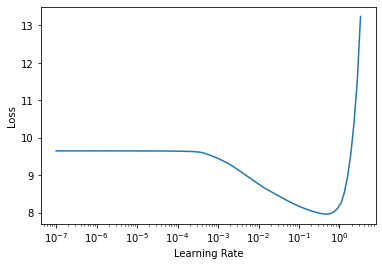

In [9]:
learn.lr_find()

In [10]:
lr = 1e-2
#lr *= bs/48  # Scale learning rate by batch size

In [11]:
cbs=[CSVLogger(fname='history_de_wikitext.csv')]

In [12]:
learn.unfreeze()
learn.fit_one_cycle(10, lr, cbs=cbs, moms=(0.8, 0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.491210,3.360344,0.394781,28.799093,20:56
1,3.389615,3.340474,0.394656,28.232515,20:47
2,3.310051,3.277328,0.401543,26.504864,20:48
3,3.270640,3.213796,0.408567,24.873329,20:47
4,3.206456,3.151273,0.415742,23.365786,20:41
5,3.157404,3.077765,0.424118,21.709837,20:44
6,3.126297,2.988825,0.434607,19.862331,20:41
7,3.074163,2.904022,0.445423,18.247379,20:36
8,3.025664,2.835042,0.454509,17.031111,20:51
9,2.997728,2.813907,0.457528,16.674938,20:36


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
lm_fns = [model_path/f'{lang}_wikitext', model_path/f'{lang}_wikitext_vocab.pkl']

In [17]:
learn.to_fp32().save(lm_fns[0].absolute(), with_opt=False)

Path('/data/projects/git/fastai_ulmfit_german/data/dewiki_lstm_15k/model/de_wikitext.pth')

In [18]:
with open(lm_fns[1], 'wb') as f:
      pickle.dump(learn.dls.vocab, f)